In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

##Load Dataset

In [23]:
import pandas as pd

file_path = "/content/drive/MyDrive/ML in GeoScience/Intersection_crashData_Clean_4.27.csv"  # Change this if using Google Drive
df = pd.read_csv(file_path)

df.columns = df.columns.str.strip()


##Understand the dataset

In [24]:
print(df.columns.tolist())

['case_id', 'description', 'Intersection_num', 'case_no.', 'unit_1_direction', 'unit_1_movement', 'unit_2_direction', 'unit_2_movement', 'unit_at_fault', 'crash_type']


##Text Preprocess

In [25]:
import pandas as pd
import re

# Input text
input_texts = df['description'].astype(str)

# Inject regex-based directional tokens
def inject_direction_tokens(text):
    text = text.lower()
    direction_patterns = {
        r'\bnorth(bound)?\b': '[DIR_NB]',
        r'\bsouth(bound)?\b': '[DIR_SB]',
        r'\beast(bound)?\b': '[DIR_EB]',
        r'\bwest(bound)?\b': '[DIR_WB]',
    }
    for pattern, token in direction_patterns.items():
        if re.search(pattern, text):
            text += f' {token}'
    return text

# Apply to all input texts
input_texts = input_texts.apply(inject_direction_tokens)

# Output columns (multiclass labels)
unit1_dir_col = "unit_1_direction"
unit1_mov_col = "unit_1_movement"
unit2_dir_col = "unit_2_direction"
unit2_mov_col = "unit_2_movement"
unit_at_fault_col = "unit_at_fault"
crash_type_col = "crash_type"

# Prepare labels
y_unit1_dir = df[unit1_dir_col]
y_unit1_mov = df[unit1_mov_col]
y_unit2_dir = df[unit2_dir_col]
y_unit2_mov = df[unit2_mov_col]
y_unit_at_fault = df[unit_at_fault_col]
y_crash_type = df[crash_type_col]


#Label Encode All Outputs

In [26]:
from sklearn.preprocessing import LabelEncoder

enc_unit1_dir = LabelEncoder()
enc_unit1_mov = LabelEncoder()
enc_unit2_dir = LabelEncoder()
enc_unit2_mov = LabelEncoder()
enc_unit_at_fault = LabelEncoder()
enc_crash_type = LabelEncoder()

y1 = enc_unit1_dir.fit_transform(y_unit1_dir)
y2 = enc_unit1_mov.fit_transform(y_unit1_mov)
y3 = enc_unit2_dir.fit_transform(y_unit2_dir)
y4 = enc_unit2_mov.fit_transform(y_unit2_mov)
y5 = enc_unit_at_fault.fit_transform(y_unit_at_fault)
y6 = enc_crash_type.fit_transform(y_crash_type)

# Now y1, y2, y3, y4, y5, y6 are integer encoded targets


In [27]:
print(len(input_texts))
print(len(y1), len(y2), len(y3), len(y4), len(y5), len(y6))

507
507 507 507 507 507 507


##Full label split for Train-Test (80-20)%

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val, y4_train, y4_val, y5_train, y5_val, y6_train, y6_val = train_test_split(
    input_texts, y1, y2, y3, y4, y5, y6,
    test_size=0.2,
    random_state=42,
    stratify=y6
)


In [29]:
from transformers import BertTokenizer

# Initialize tokenizer once
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define function
def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )


In [30]:
import torch
from torch.utils.data import Dataset

class CrashDataset(Dataset):
    def __init__(self, texts, y1, y2, y3, y4, y5, y6):
        self.encodings = tokenize_texts(texts)
        self.y1 = torch.tensor(y1, dtype=torch.long)
        self.y2 = torch.tensor(y2, dtype=torch.long)
        self.y3 = torch.tensor(y3, dtype=torch.long)
        self.y4 = torch.tensor(y4, dtype=torch.long)
        self.y5 = torch.tensor(y5, dtype=torch.long)
        self.y6 = torch.tensor(y6, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['y1'] = self.y1[idx]
        item['y2'] = self.y2[idx]
        item['y3'] = self.y3[idx]
        item['y4'] = self.y4[idx]
        item['y5'] = self.y5[idx]
        item['y6'] = self.y6[idx]
        return item

    def __len__(self):
        return len(self.y1)


##Tokenization with BERT

In [31]:
import torch.nn as nn
from transformers import BertModel

class CrashBERTMultiHead(nn.Module):
    def __init__(self, n_classes):
        super(CrashBERTMultiHead, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, n_classes[0])  # unit1_dir
        self.fc2 = nn.Linear(self.bert.config.hidden_size, n_classes[1])  # unit1_mov
        self.fc3 = nn.Linear(self.bert.config.hidden_size, n_classes[2])  # unit2_dir
        self.fc4 = nn.Linear(self.bert.config.hidden_size, n_classes[3])  # unit2_mov
        self.fc5 = nn.Linear(self.bert.config.hidden_size, n_classes[4])  # unit_at_fault
        self.fc6 = nn.Linear(self.bert.config.hidden_size, n_classes[5])  # crash_type

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.pooler_output)
        out1 = self.fc1(pooled)
        out2 = self.fc2(pooled)
        out3 = self.fc3(pooled)
        out4 = self.fc4(pooled)
        out5 = self.fc5(pooled)
        out6 = self.fc6(pooled)
        return out1, out2, out3, out4, out5, out6



In [32]:
n_classes = [
    len(enc_unit1_dir.classes_),
    len(enc_unit1_mov.classes_),
    len(enc_unit2_dir.classes_),
    len(enc_unit2_mov.classes_),
    len(enc_unit_at_fault.classes_),
    len(enc_crash_type.classes_)
]


In [33]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


cw1 = compute_class_weight('balanced', classes=np.unique(y1), y=y1_train)
cw2 = compute_class_weight('balanced', classes=np.unique(y2), y=y2_train)
cw3 = compute_class_weight('balanced', classes=np.unique(y3), y=y3_train)
cw4 = compute_class_weight('balanced', classes=np.unique(y4), y=y4_train)
#cw5 = compute_class_weight('balanced', classes=np.unique(y5), y=y5_train)
cw6 = compute_class_weight('balanced', classes=np.unique(y6), y=y6_train)


In [35]:
# Replace cw5 with this:
full_classes = enc_unit_at_fault.transform(enc_unit_at_fault.classes_)  # ensures [0,1,2,3,...] as integers

try:
    class_weights_y5 = compute_class_weight(class_weight='balanced', classes=full_classes, y=y5_train)
except ValueError:
    present_classes = np.unique(y5_train)
    partial_weights = compute_class_weight(class_weight='balanced', classes=present_classes, y=y5_train)

    class_weights_y5 = np.ones(len(full_classes), dtype=np.float32)
    for i, cls in enumerate(full_classes):
        if cls in present_classes:
            class_weights_y5[i] = partial_weights[np.where(present_classes == cls)[0][0]]
        else:
            class_weights_y5[i] = 1.0  # fallback weight

# Convert to tensor
weights_y5 = torch.tensor(class_weights_y5, dtype=torch.float).to(device)


In [36]:
# Convert to torch tensors
weights_y1 = torch.tensor(cw1, dtype=torch.float).to(device)
weights_y2 = torch.tensor(cw2, dtype=torch.float).to(device)
weights_y3 = torch.tensor(cw3, dtype=torch.float).to(device)
weights_y4 = torch.tensor(cw4, dtype=torch.float).to(device)
#weights_y5 = torch.tensor(cw5, dtype=torch.float).to(device)
weights_y6 = torch.tensor(cw6, dtype=torch.float).to(device)

In [37]:
print("Class weights for unit_at_fault:", class_weights_y5)
print("Shape:", weights_y5.shape)

Class weights for unit_at_fault: [ 1.          0.35620052 27.          6.428571  ]
Shape: torch.Size([4])


##Training Loop

In [38]:
from torch.utils.data import DataLoader

model = CrashBERTMultiHead(n_classes).to(device)

#epoch = 0
#for param in model.bert.parameters():
    #param.requires_grad = False

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn1 = nn.CrossEntropyLoss(weight=weights_y1)
loss_fn2 = nn.CrossEntropyLoss(weight=weights_y2)
loss_fn3 = nn.CrossEntropyLoss(weight=weights_y3)
loss_fn4 = nn.CrossEntropyLoss(weight=weights_y4)
loss_fn5 = nn.CrossEntropyLoss(weight=weights_y5)
loss_fn6 = nn.CrossEntropyLoss(weight=weights_y6)


train_dataset = CrashDataset(X_train, y1_train, y2_train, y3_train, y4_train, y5_train, y6_train)
val_dataset = CrashDataset(X_val, y1_val, y2_val, y3_val, y4_val, y5_val, y6_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

for epoch in range(15):
    model.train()
    total_loss = 0

#if epoch == 3:
    #for param in model.bert.parameters():
        #param.requires_grad = True

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        y1 = batch['y1'].to(device)
        y2 = batch['y2'].to(device)
        y3 = batch['y3'].to(device)
        y4 = batch['y4'].to(device)
        y5 = batch['y5'].to(device)
        y6 = batch['y6'].to(device)

        optimizer.zero_grad()
        out1, out2, out3, out4, out5, out6 = model(input_ids, attention_mask)

        loss1 = loss_fn1(out1, y1)
        loss2 = loss_fn2(out2, y2)
        loss3 = loss_fn3(out3, y3)
        loss4 = loss_fn4(out4, y4)
        loss5 = loss_fn5(out5, y5)
        loss6 = loss_fn6(out6, y6)

        loss = 1.2 * loss1 + loss2 + 1.2 * loss3 + loss4 + loss5 + loss6
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


Epoch 1, Loss: 8.685090111751183
Epoch 2, Loss: 8.123564000223197
Epoch 3, Loss: 7.821740487042596
Epoch 4, Loss: 7.490375752542533
Epoch 5, Loss: 7.199809915879193
Epoch 6, Loss: 6.752238815906001
Epoch 7, Loss: 6.288015870486989
Epoch 8, Loss: 5.701927699294745
Epoch 9, Loss: 5.101908057343726
Epoch 10, Loss: 4.500170885347853
Epoch 11, Loss: 4.165989857093961
Epoch 12, Loss: 3.652878349902583
Epoch 13, Loss: 3.29874251870548
Epoch 14, Loss: 3.021403422542647
Epoch 15, Loss: 2.7128844868903066


In [39]:
print("Class weights for Unit 1 Direction (NB, EB, SB, WB):", weights_y1)
print("Class weights for Unit 2 Direction (NB, EB, SB, WB):", weights_y3)

Class weights for Unit 1 Direction (NB, EB, SB, WB): tensor([1.2054, 0.7849, 1.0887, 1.0227])
Class weights for Unit 2 Direction (NB, EB, SB, WB): tensor([1.3682, 0.7445, 1.0025, 1.0771])


##Print one tokenized crash description

In [40]:
# Pick a sample
sample_text = input_texts.iloc[0]  # or any other index
print("Original Crash Description:\n", sample_text)

# Tokenize
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
print("\nTokenized Input:\n", tokens)


Original Crash Description:
 3300 george dieter is a two lane marked roadway north with a
adatory left turn lane going west and a two lane marked
roadaway south with a mandatory left turn lane going east.
11300 edgemere is a two lane marked roadway east and a two lane
i * ked roadway west both have a mandatory left turn lane. unit
2 was traveling south on george dieter in the right lane. unit
1 was traveling north on george dieter and making a left turn
onto edgemere. unit 1 failed to yield the right of way turning
left and caused collision with unit 2. driver of unit 1 stated
that he turned on a solid green with no arrow. driver of unit 2
as complaining of pain to both wrists but refused transport. [DIR_NB] [DIR_SB] [DIR_EB] [DIR_WB]

Tokenized Input:
 {'input_ids': tensor([[  101, 14210,  2692,  2577, 27976,  2003,  1037,  2048,  4644,  4417,
         18799,  2167,  2007,  1037, 15262,  7062,  2187,  2735,  4644,  2183,
          2225,  1998,  1037,  2048,  4644,  4417,  2346,  9497,

##How BERT Input looks like?

In [41]:
print("\nInput IDs:\n", tokens['input_ids'][0])
print("\nAttention Mask:\n", tokens['attention_mask'][0])



Input IDs:
 tensor([  101, 14210,  2692,  2577, 27976,  2003,  1037,  2048,  4644,  4417,
        18799,  2167,  2007,  1037, 15262,  7062,  2187,  2735,  4644,  2183,
         2225,  1998,  1037,  2048,  4644,  4417,  2346,  9497,  2148,  2007,
         1037, 10915,  2187,  2735,  4644,  2183,  2264,  1012, 12104,  8889,
         3341, 13759,  2003,  1037,  2048,  4644,  4417, 18799,  2264,  1998,
         1037,  2048,  4644,  1045,  1008, 16135, 18799,  2225,  2119,  2031,
         1037, 10915,  2187,  2735,  4644,  1012,  3131,  1016,  2001,  7118,
         2148,  2006,  2577, 27976,  1999,  1996,  2157,  4644,  1012,  3131,
         1015,  2001,  7118,  2167,  2006,  2577, 27976,  1998,  2437,  1037,
         2187,  2735,  3031,  3341, 13759,  1012,  3131,  1015,  3478,  2000,
        10750,  1996,  2157,  1997,  2126,  3810,  2187,  1998,  3303, 12365,
         2007,  3131,  1016,  1012,  4062,  1997,  3131,  1015,  3090,  2008,
         2002,  2357,  2006,  1037,  5024,  2665,  

##Decode the Tokens Back (See How BERT Sees Your Text)

In [42]:
decoded_text = tokenizer.decode(tokens['input_ids'][0])
print("\nDecoded Text:\n", decoded_text)



Decoded Text:
 [CLS] 3300 george dieter is a two lane marked roadway north with a adatory left turn lane going west and a two lane marked roadaway south with a mandatory left turn lane going east. 11300 edgemere is a two lane marked roadway east and a two lane i * ked roadway west both have a mandatory left turn lane. unit 2 was traveling south on george dieter in the right lane. unit 1 was traveling north on george dieter and making a left turn onto edgemere. unit 1 failed to yield the right of way turning left and caused collision with unit 2. driver of unit 1 stated that he turned on a solid green with [SEP]


##Visualize Attention Mask or Embeddings

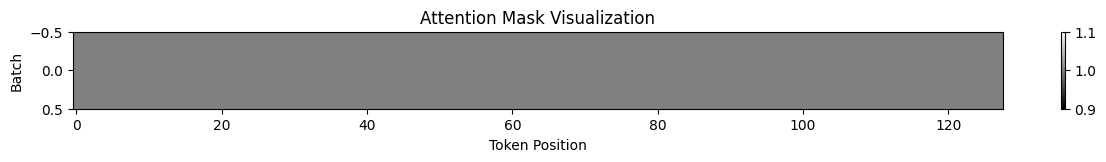

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,1))
plt.imshow(tokens['attention_mask'].numpy(), cmap='gray', aspect='auto')
plt.title('Attention Mask Visualization')
plt.xlabel('Token Position')
plt.ylabel('Batch')
plt.colorbar()
plt.show()


##Evaluate the model

In [44]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

model.eval()

all_preds_y1 = []
all_preds_y2 = []
all_preds_y3 = []
all_preds_y4 = []
all_preds_y5 = []
all_preds_y6 = []

all_true_y1 = []
all_true_y2 = []
all_true_y3 = []
all_true_y4 = []
all_true_y5 = []
all_true_y6 = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        out1, out2, out3, out4, out5, out6 = model(input_ids, attention_mask)

        preds_y1 = torch.argmax(out1, dim=1).cpu().numpy()
        preds_y2 = torch.argmax(out2, dim=1).cpu().numpy()
        preds_y3 = torch.argmax(out3, dim=1).cpu().numpy()
        preds_y4 = torch.argmax(out4, dim=1).cpu().numpy()
        preds_y5 = torch.argmax(out5, dim=1).cpu().numpy()
        preds_y6 = torch.argmax(out6, dim=1).cpu().numpy()

        all_preds_y1.extend(preds_y1)
        all_preds_y2.extend(preds_y2)
        all_preds_y3.extend(preds_y3)
        all_preds_y4.extend(preds_y4)
        all_preds_y5.extend(preds_y5)
        all_preds_y6.extend(preds_y6)

        all_true_y1.extend(batch['y1'].cpu().numpy())
        all_true_y2.extend(batch['y2'].cpu().numpy())
        all_true_y3.extend(batch['y3'].cpu().numpy())
        all_true_y4.extend(batch['y4'].cpu().numpy())
        all_true_y5.extend(batch['y5'].cpu().numpy())
        all_true_y6.extend(batch['y6'].cpu().numpy())


In [45]:
# For Unit 1 Direction
print("Unit 1 Direction - Accuracy:", accuracy_score(all_true_y1, all_preds_y1))
print("Unit 1 Direction - F1 Score (macro):", f1_score(all_true_y1, all_preds_y1, average='macro'))

# For Unit 1 Movement
print("\nUnit 1 Movement - Accuracy:", accuracy_score(all_true_y2, all_preds_y2))
print("Unit 1 Movement - F1 Score (macro):", f1_score(all_true_y2, all_preds_y2, average='macro'))

# For Unit 2 Direction
print("\nUnit 2 Direction - Accuracy:", accuracy_score(all_true_y3, all_preds_y3))
print("Unit 2 Direction - F1 Score (macro):", f1_score(all_true_y3, all_preds_y3, average='macro'))

# For Unit 2 Movement
print("\nUnit 2 Movement - Accuracy:", accuracy_score(all_true_y4, all_preds_y4))
print("Unit 2 Movement - F1 Score (macro):", f1_score(all_true_y4, all_preds_y4, average='macro'))

# For unit at fault
print("\nUnit at Fault - Accuracy:", accuracy_score(all_true_y5, all_preds_y5))
print("Unit at Fault - F1 Score (macro):", f1_score(all_true_y5, all_preds_y5, average='macro'))

# For Crash Type
print("\nCrash Type - Accuracy:", accuracy_score(all_true_y6, all_preds_y6))
print("Crash Type - F1 Score (macro):", f1_score(all_true_y6, all_preds_y6, average='macro'))


Unit 1 Direction - Accuracy: 0.6862745098039216
Unit 1 Direction - F1 Score (macro): 0.6882284382284383

Unit 1 Movement - Accuracy: 0.7647058823529411
Unit 1 Movement - F1 Score (macro): 0.5259742738272454

Unit 2 Direction - Accuracy: 0.7058823529411765
Unit 2 Direction - F1 Score (macro): 0.6945171801809665

Unit 2 Movement - Accuracy: 0.803921568627451
Unit 2 Movement - F1 Score (macro): 0.40380952380952384

Unit at Fault - Accuracy: 0.8627450980392157
Unit at Fault - F1 Score (macro): 0.23157894736842105

Crash Type - Accuracy: 0.6568627450980392
Crash Type - F1 Score (macro): 0.3262623417647654


In [46]:
print("\nCrash Type Classification Report:\n")
print(classification_report(all_true_y6, all_preds_y6))


Crash Type Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.65      0.81      0.72        27
           3       0.90      0.74      0.81        47
           4       0.35      0.55      0.43        11
           5       0.33      0.31      0.32        13
           6       0.00      0.00      0.00         1

    accuracy                           0.66       102
   macro avg       0.32      0.34      0.33       102
weighted avg       0.67      0.66      0.65       102



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision=	TP / (TP + FP)	(Exactness)

Recall=	TP / (TP + FN)	(Completeness)

F1 Score=	2 × (Precision × Recall) / (Precision + Recall)	(Balance)

Support=	Count of true positives in ground truth	(Frequency)

In [47]:
from sklearn.metrics import classification_report

print("\nUnit 1 Direction Classification Report:\n")
print(classification_report(all_true_y1, all_preds_y1))



Unit 1 Direction Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        20
           1       0.79      0.58      0.67        38
           2       0.60      0.82      0.69        22
           3       0.73      0.73      0.73        22

    accuracy                           0.69       102
   macro avg       0.69      0.71      0.69       102
weighted avg       0.70      0.69      0.69       102



In [48]:
print("\nUnit 2 Direction Classification Report:\n")
print(classification_report(all_true_y3, all_preds_y3))


Unit 2 Direction Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.57      0.63        21
           1       0.73      0.68      0.70        28
           2       0.72      0.84      0.78        31
           3       0.65      0.68      0.67        22

    accuracy                           0.71       102
   macro avg       0.70      0.69      0.69       102
weighted avg       0.71      0.71      0.70       102



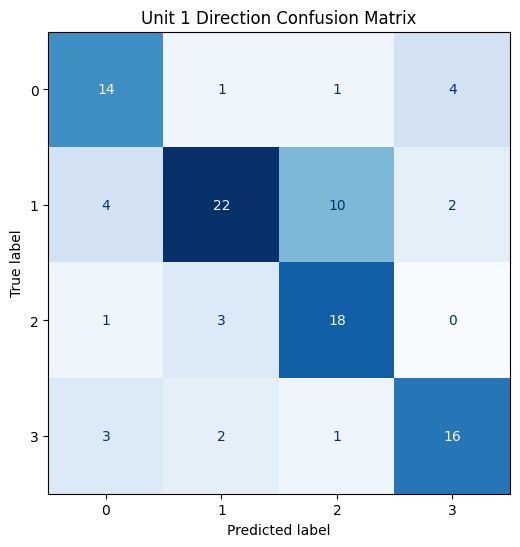

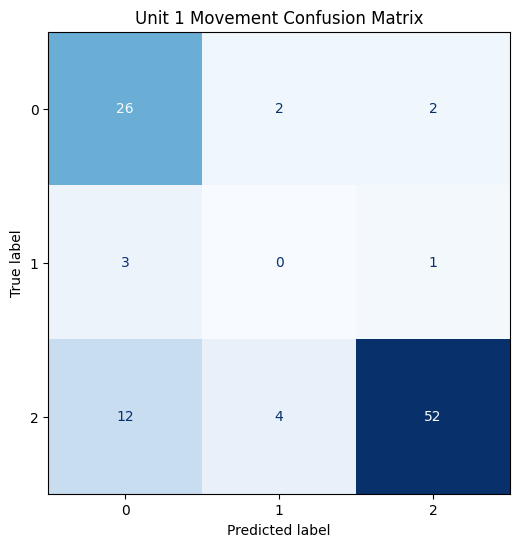

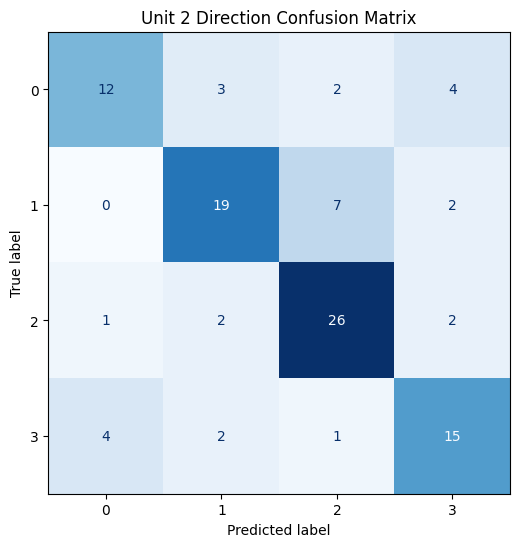

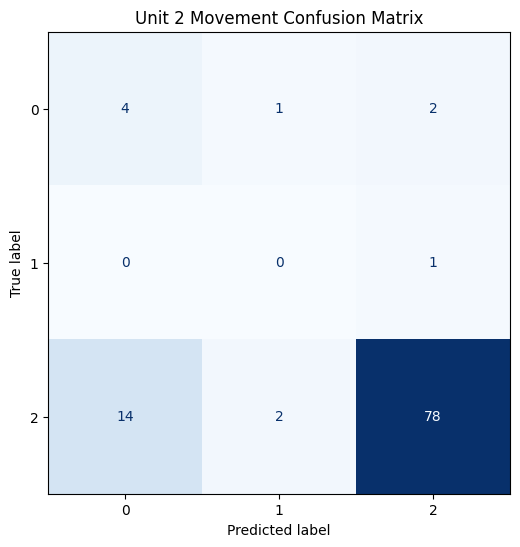

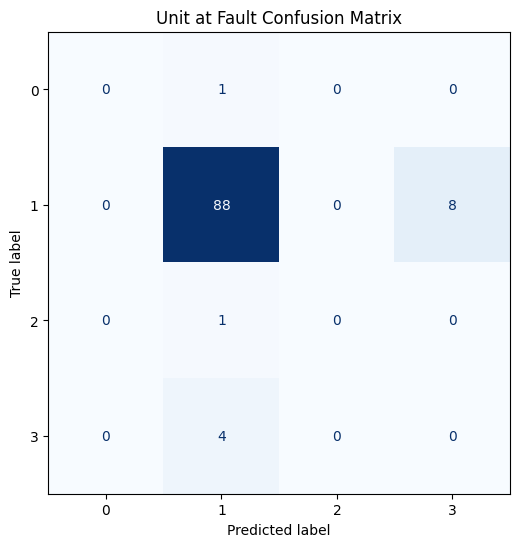

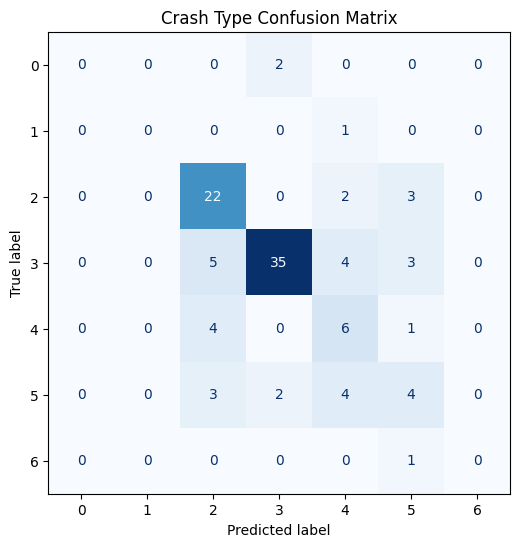

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    plt.title(title)
    plt.show()

# Optional: define labels if you have LabelEncoders
# Otherwise, labels are just class indices: 0, 1, 2, etc.

# Plot for each output
plot_conf_matrix(all_true_y1, all_preds_y1, "Unit 1 Direction Confusion Matrix")
plot_conf_matrix(all_true_y2, all_preds_y2, "Unit 1 Movement Confusion Matrix")
plot_conf_matrix(all_true_y3, all_preds_y3, "Unit 2 Direction Confusion Matrix")
plot_conf_matrix(all_true_y4, all_preds_y4, "Unit 2 Movement Confusion Matrix")
plot_conf_matrix(all_true_y5, all_preds_y5, "Unit at Fault Confusion Matrix")
plot_conf_matrix(all_true_y6, all_preds_y6, "Crash Type Confusion Matrix")


Predicted 0	  Predicted 1

True 0	  TN	FP

True 1	  FN	TP